# Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Dataset

In [2]:
class Places365Train(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

In [3]:
DATASET_PATH = Path("/kaggle/input/sust-coco/kaggle/working/whole_ds")

In [4]:
dataset = Places365Train(DATASET_PATH)

In [5]:
print(len(dataset))

5896


In [6]:
print(dataset[0][0].shape, dataset[0][1].shape)

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


Showing 16 samples from training set torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


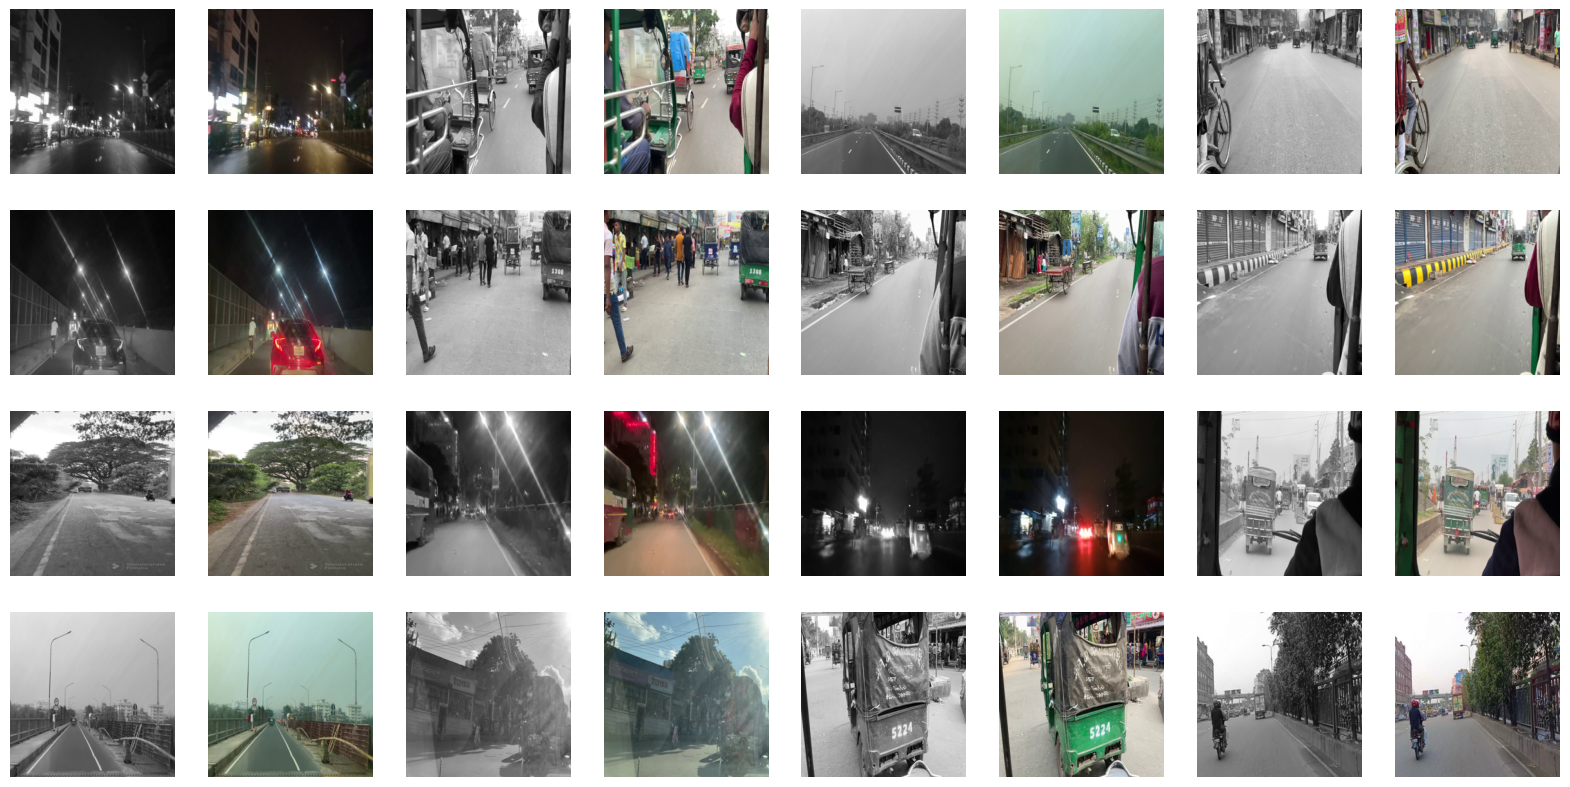

In [7]:
import matplotlib.pyplot as plt

random_sampler = RandomSampler(dataset, num_samples=16)
random_loader = DataLoader(dataset, batch_size=16, sampler=random_sampler)
plt.figure(figsize=(20, 10))
for x, y in random_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(x[i].permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)
        plt.imshow(y[i].permute(1, 2, 0))
        plt.axis("off")

# Base Model

In [8]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [9]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8

        out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
        out += feature640
        out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
        out += feature224
        out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
        out += feature80
        out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
        out += feature48
        out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
        out += feature32
        out = self.colorization_layers[7:10](
            out
        )  # 32x256x256 -> 64x256x256 -> 2x256x256

        return out

In [10]:
model = ConvNetWithEfficientNetFeatureExtractor().to("cuda")

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:14<00:00, 18.1MB/s]


In [11]:
inp = dataset[0][0].unsqueeze(0).to("cuda")
print(inp.shape)

torch.Size([1, 3, 256, 256])


In [12]:
out = model(inp)
out.shape

torch.Size([1, 3, 256, 256])

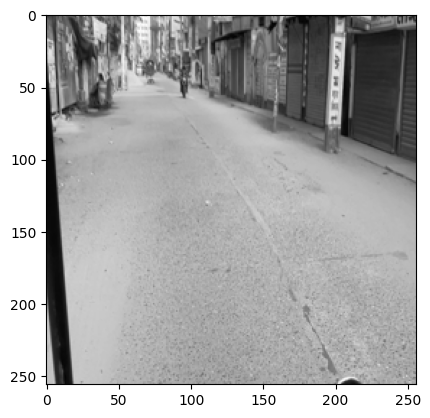

In [13]:
plt.imshow(inp[0].permute(1, 2, 0).cpu())

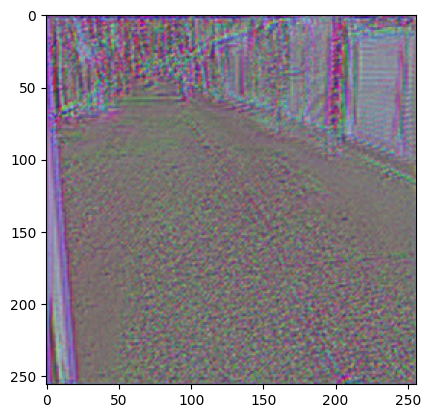

In [14]:
output_img = out.detach()[0].cpu()
plt.imshow(output_img.permute(1, 2, 0))

# Perceptual Loss Model

In [15]:
import torchvision.models as models

# Load the pre-trained VGG11 model
vgg11 = models.vgg11(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:09<00:00, 55.8MB/s]


In [16]:
vgg11 = vgg11.features  # Only need the feature extractor

In [17]:
from torch.nn import MSELoss

criterion = MSELoss()

In [18]:
for param in vgg11.parameters():
    param.requires_grad = False

In [19]:
i1 = torch.randn((3, 224, 224))
i1.requires_grad = True

v1 = vgg11(i1)
v2 = vgg11(torch.randn((3, 224, 224)))

criterion(v1, v2)

tensor(0.0279, grad_fn=<MseLossBackward0>)

In [20]:
vgg11 = vgg11.to("cuda")

# Train With Perceptual Loss

In [21]:
from torch.optim import AdamW
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001)
criterion = MSELoss()

In [22]:
torch.cuda.empty_cache()

In [23]:
train_loader, val_loader = train_test_split(dataset, test_size=0.1, random_state=42)
train_loader = DataLoader(train_loader, batch_size=64, shuffle=True)
val_loader = DataLoader(val_loader, batch_size=64, shuffle=False)

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y) + criterion(vgg11(output), vgg11(y))

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        #         train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader):
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item()
        #             val_loss /= len(val_loader)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

In [25]:
train(model, train_loader, val_loader, criterion, optimizer, device, epochs=150)

100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 1/150, Train Loss: 9.1577, Val Loss: 0.4304


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 2/150, Train Loss: 5.1730, Val Loss: 0.3386


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 3/150, Train Loss: 4.6018, Val Loss: 0.2246


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 4/150, Train Loss: 4.2754, Val Loss: 0.1352


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 5/150, Train Loss: 4.0297, Val Loss: 0.0860


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 6/150, Train Loss: 3.8543, Val Loss: 0.0601


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 7/150, Train Loss: 3.6568, Val Loss: 0.0452


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 8/150, Train Loss: 3.5450, Val Loss: 0.0398


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 9/150, Train Loss: 3.4164, Val Loss: 0.0320


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 10/150, Train Loss: 3.3350, Val Loss: 0.0291


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 11/150, Train Loss: 3.2526, Val Loss: 0.0279


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 12/150, Train Loss: 3.1777, Val Loss: 0.0266


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 13/150, Train Loss: 3.1124, Val Loss: 0.0255


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 14/150, Train Loss: 3.0544, Val Loss: 0.0258


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 15/150, Train Loss: 3.0051, Val Loss: 0.0264


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 16/150, Train Loss: 2.9453, Val Loss: 0.0254


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 17/150, Train Loss: 2.8925, Val Loss: 0.0256


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 18/150, Train Loss: 2.8599, Val Loss: 0.0248


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 19/150, Train Loss: 2.7920, Val Loss: 0.0248


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 20/150, Train Loss: 2.7628, Val Loss: 0.0252


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 21/150, Train Loss: 2.7431, Val Loss: 0.0246


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 22/150, Train Loss: 2.6778, Val Loss: 0.0249


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 23/150, Train Loss: 2.6855, Val Loss: 0.0239


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 24/150, Train Loss: 2.6461, Val Loss: 0.0242


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 25/150, Train Loss: 2.6136, Val Loss: 0.0239


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 26/150, Train Loss: 2.5764, Val Loss: 0.0235


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 27/150, Train Loss: 2.5482, Val Loss: 0.0248


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 28/150, Train Loss: 2.5258, Val Loss: 0.0237


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 29/150, Train Loss: 2.5210, Val Loss: 0.0238


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 30/150, Train Loss: 2.4677, Val Loss: 0.0234


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 31/150, Train Loss: 2.4502, Val Loss: 0.0230


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 32/150, Train Loss: 2.4582, Val Loss: 0.0241


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 33/150, Train Loss: 2.4161, Val Loss: 0.0234


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 34/150, Train Loss: 2.3817, Val Loss: 0.0229


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 35/150, Train Loss: 2.3692, Val Loss: 0.0234


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 36/150, Train Loss: 2.3577, Val Loss: 0.0228


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 37/150, Train Loss: 2.3457, Val Loss: 0.0229


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 38/150, Train Loss: 2.3146, Val Loss: 0.0228


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 39/150, Train Loss: 2.2923, Val Loss: 0.0227


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 40/150, Train Loss: 2.3033, Val Loss: 0.0223


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 41/150, Train Loss: 2.2578, Val Loss: 0.0224


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 42/150, Train Loss: 2.2423, Val Loss: 0.0222


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 43/150, Train Loss: 2.2385, Val Loss: 0.0223


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 44/150, Train Loss: 2.2142, Val Loss: 0.0220


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 45/150, Train Loss: 2.2082, Val Loss: 0.0224


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 46/150, Train Loss: 2.2166, Val Loss: 0.0221


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 47/150, Train Loss: 2.1885, Val Loss: 0.0221


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 48/150, Train Loss: 2.1724, Val Loss: 0.0221


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 49/150, Train Loss: 2.1455, Val Loss: 0.0220


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 50/150, Train Loss: 2.1255, Val Loss: 0.0217


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 51/150, Train Loss: 2.1031, Val Loss: 0.0222


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 52/150, Train Loss: 2.1276, Val Loss: 0.0218


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 53/150, Train Loss: 2.1083, Val Loss: 0.0231


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 54/150, Train Loss: 2.0793, Val Loss: 0.0215


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 55/150, Train Loss: 2.0881, Val Loss: 0.0223


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 56/150, Train Loss: 2.0741, Val Loss: 0.0212


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 57/150, Train Loss: 2.0598, Val Loss: 0.0218


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 58/150, Train Loss: 2.0364, Val Loss: 0.0213


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 59/150, Train Loss: 2.0291, Val Loss: 0.0219


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 60/150, Train Loss: 2.0347, Val Loss: 0.0225


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 61/150, Train Loss: 2.0077, Val Loss: 0.0213


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 62/150, Train Loss: 1.9908, Val Loss: 0.0213


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 63/150, Train Loss: 2.0055, Val Loss: 0.0214


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 64/150, Train Loss: 1.9679, Val Loss: 0.0211


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 65/150, Train Loss: 1.9573, Val Loss: 0.0212


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 66/150, Train Loss: 1.9655, Val Loss: 0.0218


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 67/150, Train Loss: 1.9667, Val Loss: 0.0213


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 68/150, Train Loss: 1.9473, Val Loss: 0.0208


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 69/150, Train Loss: 1.9288, Val Loss: 0.0212


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 70/150, Train Loss: 1.9253, Val Loss: 0.0211


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 71/150, Train Loss: 1.9062, Val Loss: 0.0211


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 72/150, Train Loss: 1.8987, Val Loss: 0.0214


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 73/150, Train Loss: 1.8817, Val Loss: 0.0207


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 74/150, Train Loss: 1.8948, Val Loss: 0.0207


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 75/150, Train Loss: 1.9023, Val Loss: 0.0210


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 76/150, Train Loss: 1.8843, Val Loss: 0.0208


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 77/150, Train Loss: 1.8890, Val Loss: 0.0210


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 78/150, Train Loss: 1.8516, Val Loss: 0.0207


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 79/150, Train Loss: 1.8279, Val Loss: 0.0206


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 80/150, Train Loss: 1.8609, Val Loss: 0.0207


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 81/150, Train Loss: 1.8525, Val Loss: 0.0208


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 82/150, Train Loss: 1.8662, Val Loss: 0.0214


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 83/150, Train Loss: 1.8317, Val Loss: 0.0210


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 84/150, Train Loss: 1.8392, Val Loss: 0.0206


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 85/150, Train Loss: 1.8081, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 86/150, Train Loss: 1.7939, Val Loss: 0.0206


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 87/150, Train Loss: 1.8034, Val Loss: 0.0205


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 88/150, Train Loss: 1.7876, Val Loss: 0.0213


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 89/150, Train Loss: 1.7761, Val Loss: 0.0199


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 90/150, Train Loss: 1.7976, Val Loss: 0.0204


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 91/150, Train Loss: 1.7722, Val Loss: 0.0202


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 92/150, Train Loss: 1.7606, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 93/150, Train Loss: 1.7729, Val Loss: 0.0209


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 94/150, Train Loss: 1.7577, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 95/150, Train Loss: 1.7535, Val Loss: 0.0204


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 96/150, Train Loss: 1.7347, Val Loss: 0.0205


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 97/150, Train Loss: 1.7341, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 98/150, Train Loss: 1.7327, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 99/150, Train Loss: 1.7110, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 100/150, Train Loss: 1.7067, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 101/150, Train Loss: 1.6984, Val Loss: 0.0204


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 102/150, Train Loss: 1.6997, Val Loss: 0.0208


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 103/150, Train Loss: 1.7139, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 104/150, Train Loss: 1.6902, Val Loss: 0.0208


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 105/150, Train Loss: 1.7189, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 106/150, Train Loss: 1.6818, Val Loss: 0.0204


100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch 107/150, Train Loss: 1.6960, Val Loss: 0.0202


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 108/150, Train Loss: 1.6683, Val Loss: 0.0199


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 109/150, Train Loss: 1.6721, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 110/150, Train Loss: 1.6635, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 111/150, Train Loss: 1.6624, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 112/150, Train Loss: 1.6603, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 113/150, Train Loss: 1.6483, Val Loss: 0.0204


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 114/150, Train Loss: 1.6592, Val Loss: 0.0199


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 115/150, Train Loss: 1.6404, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 116/150, Train Loss: 1.6436, Val Loss: 0.0203


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 117/150, Train Loss: 1.6216, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 118/150, Train Loss: 1.6094, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 119/150, Train Loss: 1.6226, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 120/150, Train Loss: 1.6318, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 121/150, Train Loss: 1.6143, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 122/150, Train Loss: 1.6200, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 123/150, Train Loss: 1.5983, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 124/150, Train Loss: 1.6069, Val Loss: 0.0196


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 125/150, Train Loss: 1.5932, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 126/150, Train Loss: 1.5894, Val Loss: 0.0196


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 127/150, Train Loss: 1.5843, Val Loss: 0.0202


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch 128/150, Train Loss: 1.5779, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 129/150, Train Loss: 1.5708, Val Loss: 0.0199


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 130/150, Train Loss: 1.6138, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 131/150, Train Loss: 1.6084, Val Loss: 0.0200


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 132/150, Train Loss: 1.5772, Val Loss: 0.0196


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch 133/150, Train Loss: 1.5772, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 134/150, Train Loss: 1.5504, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 135/150, Train Loss: 1.5479, Val Loss: 0.0195


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 136/150, Train Loss: 1.5458, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 137/150, Train Loss: 1.5520, Val Loss: 0.0196


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 138/150, Train Loss: 1.5378, Val Loss: 0.0201


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 139/150, Train Loss: 1.5551, Val Loss: 0.0195


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 140/150, Train Loss: 1.5470, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 141/150, Train Loss: 1.5254, Val Loss: 0.0198


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 142/150, Train Loss: 1.5328, Val Loss: 0.0194


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 143/150, Train Loss: 1.5459, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 144/150, Train Loss: 1.5273, Val Loss: 0.0199


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 145/150, Train Loss: 1.5528, Val Loss: 0.0197


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 146/150, Train Loss: 1.5189, Val Loss: 0.0195


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Epoch 147/150, Train Loss: 1.5383, Val Loss: 0.0196


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 148/150, Train Loss: 1.5188, Val Loss: 0.0195


100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch 149/150, Train Loss: 1.5178, Val Loss: 0.0195


100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Epoch 150/150, Train Loss: 1.5134, Val Loss: 0.0195


In [26]:
torch.save(model.state_dict(), "model.pth")

# Inference

In [27]:
MODEL_PATH = "model.pth"

In [28]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

torch.Size([1, 3, 256, 256])


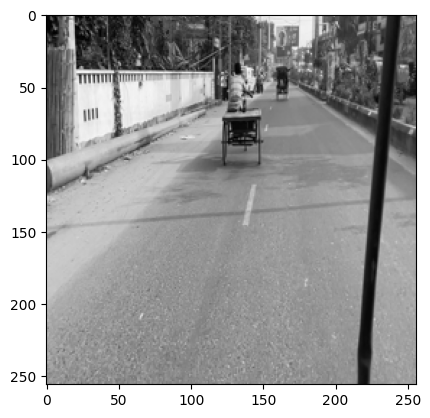

In [29]:
SAMPLE_IDX = 100

inp = dataset[SAMPLE_IDX][0].unsqueeze(0)
print(inp.shape)
plt.imshow(inp[0].permute(1, 2, 0))

torch.Size([1, 3, 256, 256])


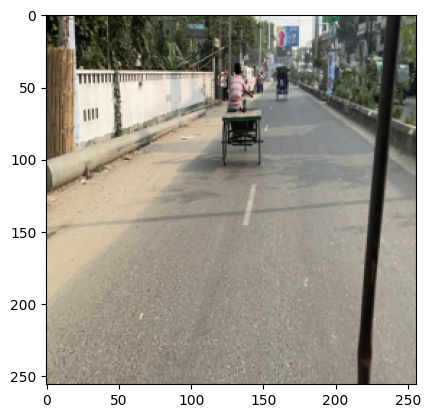

In [30]:
gt = dataset[SAMPLE_IDX][1].unsqueeze(0)
print(gt.shape)
plt.imshow(gt[0].permute(1, 2, 0).cpu())

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


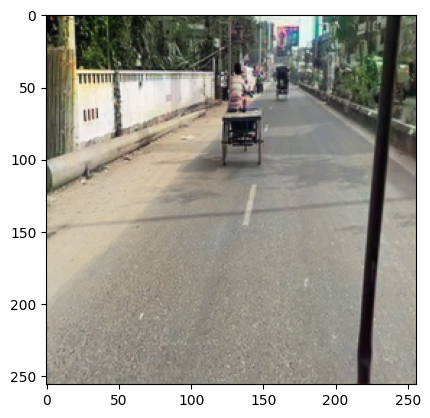

In [31]:
out = model(inp.to("cuda"))
print(out.shape)
output_img = out.detach()[0].cpu()
print(output_img.shape)
plt.imshow(output_img.permute(1, 2, 0))

Showing 16 samples from training set torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


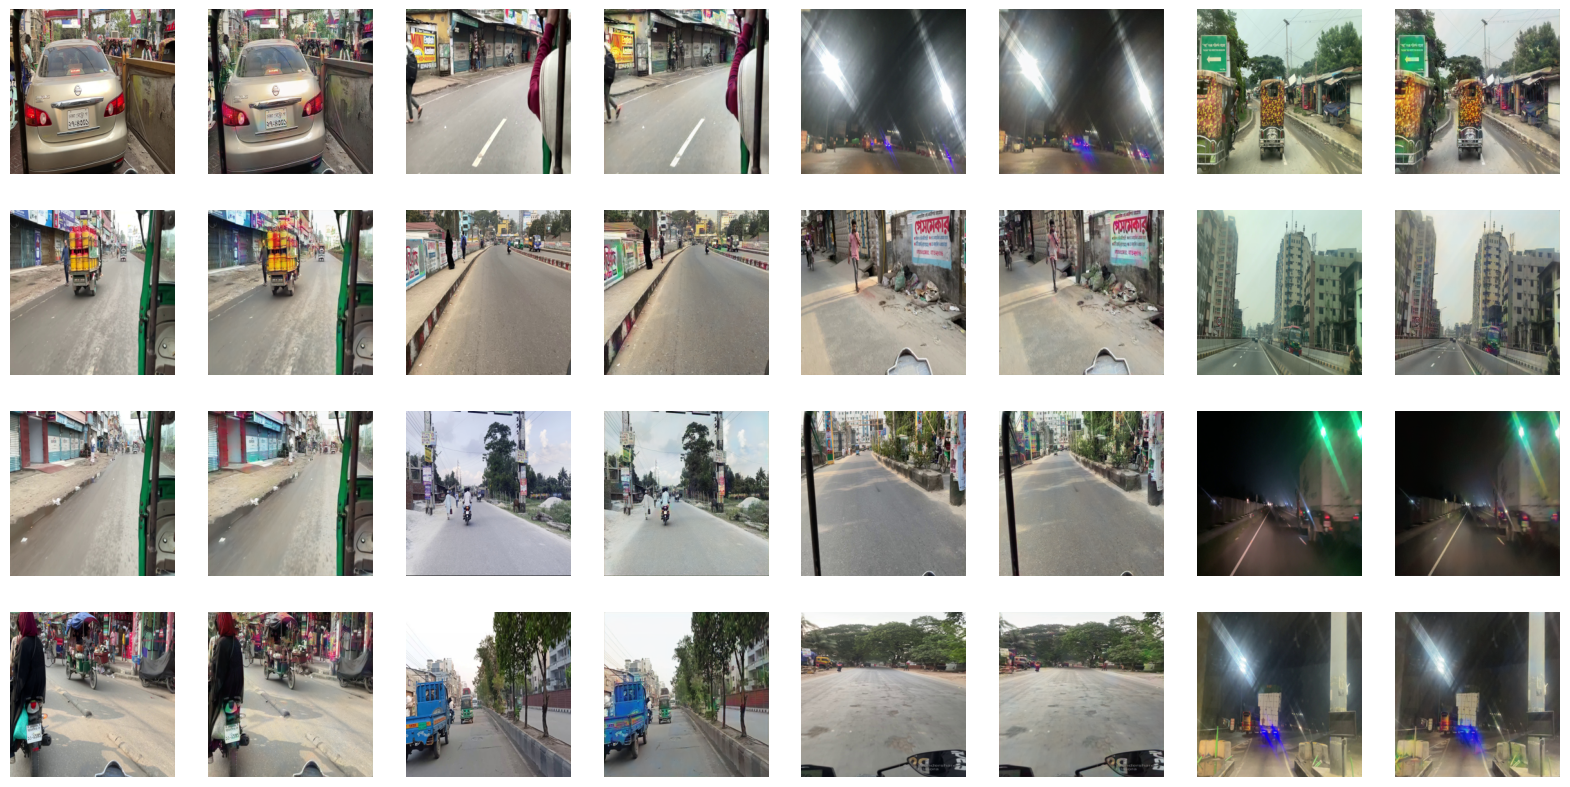

In [32]:
random_sampler = RandomSampler(dataset, num_samples=16)
random_loader = DataLoader(dataset, batch_size=16, sampler=random_sampler)
plt.figure(figsize=(20, 10))
for x, y in random_loader:
    x: torch.Tensor
    y: torch.Tensor
    n = min(x.shape[0], 16)
    print(f"Showing {n} samples from training set", x.shape, y.shape)
    for i in range(n):
        # x: input, grayscale
        plt.subplot(4, 8, i * 2 + 1)
        plt.imshow(y[i].permute(1, 2, 0))
        plt.axis("off")
        # y: ground truth
        plt.subplot(4, 8, i * 2 + 2)

        inp = x[i].to("cuda").unsqueeze(0)
        out = model(inp)
        out_img = out.detach()[0].cpu()
        plt.imshow(out_img.permute(1, 2, 0))
        plt.axis("off")